# HDDM Tutorial: Example script using Ostwald's data

This is the script for illustrating a principled workflow of hierarchical bayesian drift diffusion modelling. We used data from Ostwald (Geogie et al, 2018; Ostwald et al., 2012) as an example

**Reference of the data**

Georgie, Yasmin K., Camillo Porcaro, Stephen D. Mayhew, Andrew P. Bagshaw, and Dirk Ostwald. “A Perceptual Decision Making EEG/FMRI Data Set.” BioRxiv, January 25, 2018, 253047. https://doi.org/10.1101/253047.

Ostwald, Dirk, Camillo Porcaro, Stephen D. Mayhew, and Andrew P. Bagshaw. “EEG-FMRI Based Information Theoretic Characterization of the Human Perceptual Decision System.” PLOS ONE 7, no. 4 (April 2, 2012): e33896. https://doi.org/10.1371/journal.pone.0033896.

## Test installed packages

Please make sure that you've installed docker and pulled the [`hcp4715/hddm:viz`](https://hub.docker.com/r/hcp4715/hddm) image.

The code below is testing whether you are using the corrent docker image. Run the code block below, you should see output like this:

`Notebook is running: /opt/conda/bin/python` 

`The current Python version is 3.7.10`

`The current HDDM version is 0.8.0`

`The current Kabuki version is 0.6.3`

`The current PyMC version is 2.3.8`

`The current IPython version is 7.15.0`

`The current Numpy version is 1.19.1`

`The current Pandas version is 1.0.5`

`The current seaborn version is 0.11.0`


In [1]:
# check the current python version, make sure this is the one that with HDDM correctly installed
import sys
sys.executable

# check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# further check your python version
from platform import python_version

print('The current Python version is', python_version())

# If you are sure that conda is installed, also check the package that install
#!conda list  # list the conda

import hddm, IPython, kabuki, pymc
import numpy as np
import pandas as pd
import seaborn as sns
print('The current HDDM version is', hddm.__version__) # 0.8.0
print('The current IPython version is', IPython.__version__) 
print('The current Numpy version is', np.__version__) 
print('The current Pandas version is', pd.__version__)
print('The current seaborn version is', sns.__version__)

print('The current Kabuki version is', kabuki.__version__) # 0.6.3
print('The current PyMC version is', pymc.__version__) # 2.3.8

Notebook is running: /opt/conda/bin/python
The current Python version is 3.7.10
The current HDDM version is 0.8.0
The current Kabuki version is 0.6.3
The current PyMC version is 2.3.8
The current IPython version is 7.15.0
The current Numpy version is 1.19.1
The current Pandas version is 1.0.5
The current seaborn version is 0.11.0


/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Import packages need for analyses

In [2]:
%matplotlib inline

# Preparation
import os, hddm, time, csv
import kabuki 
import datetime

# import the toolbox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns

# set the color of plots
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

In [4]:
# load data, note that I have preprocessed Ostwald's data so that it fit HDDM's format
df = hddm.load_csv('df_Ostwald.csv')
df.head() 

# preprocessing the data to get a accuracy-coding version
# df_m1 = df.drop(['response'], axis=1)
# df_m1 = df_m1.rename(columns={'accuracy':'response'})  # change the column name to 
# df_m1.head()
# df_m1.to_csv('df_Ostwald_acc_code.csv', index=False)

,subj_idx,status,runid,condition,cue,coherence,image_index,stim,response,rt,accuracy,stimulus_side
0,1,outside,1,1,valid,high,19,1,1,0.529206,1,0
1,1,outside,1,2,invalid,high,12,0,0,0.519501,1,0
2,1,outside,1,2,invalid,high,20,1,1,0.611204,1,0
3,1,outside,1,1,valid,high,5,0,0,0.465089,1,0
4,1,outside,1,1,valid,high,13,0,0,0.367166,1,1


## Visualization of the data

### Information about the experiment (recap)
This dataset was based on a 2 by 2 by 2 within subject design, with factors stimulus coherence (low, high) and spatial prioritization (yes, no). 

Data are from 17 participants (8 female, mean age 25.9 yrs, rang 20 ~ 33, 2 left-handed) recruited from University of Birmingham. 

Original stimulus set include 18 pictures of cars and 18 pictures of faces. 

Procedure:

EEG experiment outside MRI scanner (72 trials/condition) --> EEG inside scanner (90 trials/condition)

We preprocessed the behavioral data so that all data are now in the same `csv` file.  

 * stim ---- 1 means face; 0 means car
 * response ---- 1 means paratcipants they pressed the face button; 0 means they pressed the car button
 
Note: We also have a second `csv` file (`df_Ostwald_acc_code.csv`) for accuracy coding, where the `response` is the accuracy instead the key participants pressed.

### The way HDDM visualizes data

Below is the way to visualize the raw data as demonstrated in HDDM's tutorial.

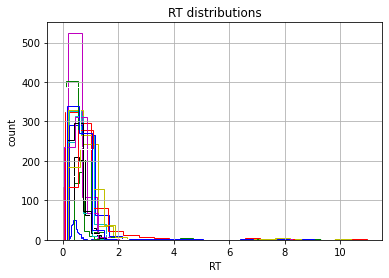

In [4]:
# plot and save the distribution of raw data:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in df.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# plt.savefig('plot_df_behav_ostwald.pdf')

### Multiple (better) ways to visualize the data in Python

#### First, visualize the summary data, as presented in the [preprint](https://www.biorxiv.org/content/10.1101/253047v1)

Here, we demonstrated two ways to visualize the data: bar plots (with error bar) and raincloud plots.

Before we jump into the plots, we can also check the number of trials for each condition of each participant.

In [5]:
df["cond"] = df["cue"] + "_" + df["coherence"]

# check the trials for accurate and wrong responses
df.groupby(['status', 'subj_idx', 'cond', 'accuracy']).size()

status   subj_idx  cond          accuracy
inside   2         invalid_high  0            3
                                 1           87
                   invalid_low   0           12
                                 1           75
                   valid_high    0            5
                                             ..
outside  17        invalid_low   1           56
                   valid_high    0            1
                                 1           71
                   valid_low     0           12
                                 1           60
Length: 247, dtype: int64

When visualize the data, we tried to replicate the Figure 2a in Georgie et al (2018). 

First, get the median of each condition for each participant, then, plot the mean and SD (instead of SE in the manuscript).

The plot looks like a bit different to the Fig 2a in the preprint.

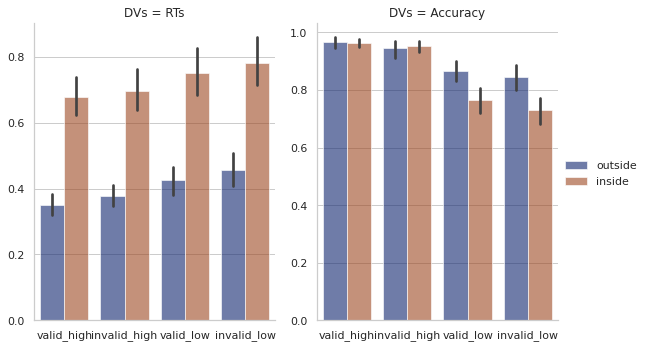

In [6]:
# get the median of accurate RTs
df_rt_sum = df[df['accuracy'] ==1].groupby(['subj_idx','status', 'cond'])['rt'].median().reset_index()

# get the mean accuracy (this approach is not optimal)
df_acc_sum = df.groupby(['subj_idx','status', 'cond'])['accuracy'].mean().reset_index()

# categorize the cond and order the data
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['valid_high', 'invalid_high', 'valid_low', 'invalid_low'],
                           ordered=True)
df_rt_sum['cond'] = df_rt_sum['cond'].astype(cat_type)
df_acc_sum['cond'] = df_acc_sum['cond'].astype(cat_type)

df_rt_sum['DVs'] = 'RTs'
df_rt_sum.rename(columns={'rt':'value'}, inplace=True)
df_acc_sum['DVs'] = 'Accuracy'
df_acc_sum.rename(columns={'accuracy':'value'}, inplace=True)

df_sum = pd.concat([df_rt_sum, df_acc_sum]).reset_index(drop=True)  # concat two dataframes
df_sum['cond'] = df_sum['cond'].astype(cat_type)

### MUST use map_dataframe()
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(data=df_sum, col="DVs", height=5, aspect=.8, sharex=True, sharey=False)
g.map_dataframe(sns.barplot, x='cond', y="value", hue = 'status', 
                order=['valid_high', 'invalid_high', 'valid_low', 'invalid_low'],
                #ci = 'sd', # not used, boostrap confidence interval will be used?
                palette="dark", alpha=.6,)
g.add_legend()

We can also used the [`raincloud` plot](https://wellcomeopenresearch.org/articles/4-63/v2), which shows both the individual data and group data.

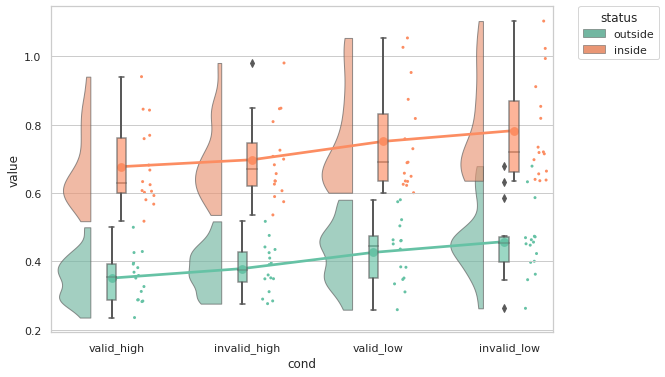

In [7]:
# plot raincloud of RT
import ptitprince as pt

dx = "cond"; dy = "value"; dhue = "status"; ort = "v"; pal = "Set2"; sigma = .4

f, ax = plt.subplots(figsize=(9, 6))

ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=df_rt_sum, palette=pal, 
                  bw=sigma, width_viol=.5,
                  ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

We also need to visual inspect individual data. So we will plot individual data using interactive plots `plotly`.

In [8]:
df_p = df.set_index(['subj_idx'])
df_p.describe()

,runid,condition,image_index,stim,response,rt,accuracy,stimulus_side
count,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000
mean,2.326997,2.500441,36.362959,0.499461,0.524057,0.705192,0.877413,0.500735
std,1.333751,1.118571,20.778497,0.500024,0.499445,0.746310,0.327979,0.500024
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000117,0.000000,0.000000
25%,1.000000,1.000000,19.000000,0.000000,0.000000,0.413091,1.000000,0.000000
50%,2.000000,3.000000,37.000000,0.000000,1.000000,0.593741,1.000000,1.000000
75%,3.000000,4.000000,54.000000,1.000000,1.000000,0.772207,1.000000,1.000000
max,5.000000,4.000000,72.000000,1.000000,1.000000,10.953051,1.000000,1.000000


In [9]:
# import packages and function for interactive plotting
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot,iplot_mpl
from plotly.graph_objs import *
import cufflinks as cf
init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [10]:
@interact(index_name=df_p.index.unique())  # can we use subject's number as the index_name?
def iplot_scale(index_name):
    df_tmp = df_p[df_p.index==index_name]['rt']
    iplot(df_tmp.iplot(asFigure=True,kind='histogram', bins = 20,subplots=True, shape=(1, 1), filename='histogram-subplots'))

interactive(children=(Dropdown(description='index_name', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

## Traditional analyses (optional in the future, can be removed)

In case we also want to use traditional Bayesian hierarchical model using `pymc3` and [`bambi`](https://github.com/bambinos/bambi), e.g., using signal detection theory to model accuracy and `shifted log normal` to model RTs. So I tested these tools inside this docker image, using `bambi`'s example.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x2, x1, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb13fc96090>,
      dtype=object)

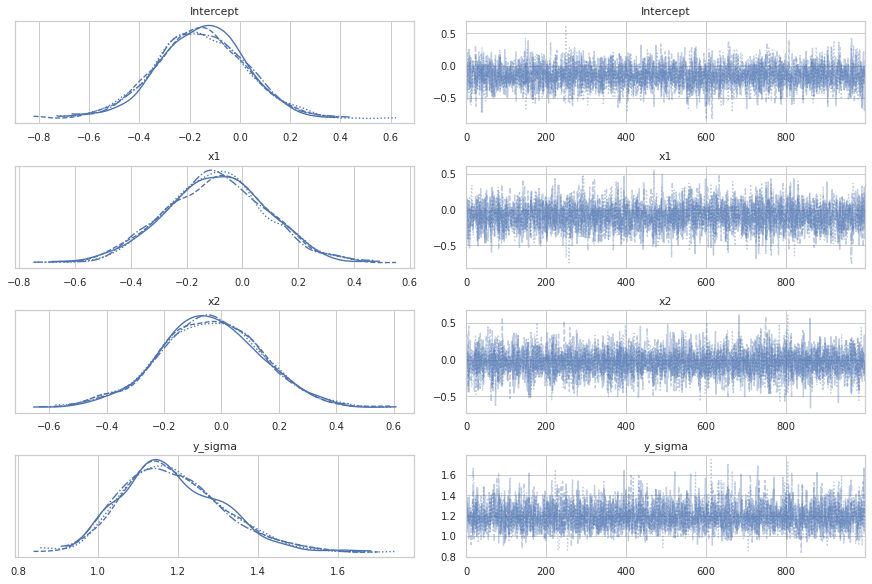

In [11]:
import bambi as bmb
import arviz as az

# check whether bambi works
data = pd.DataFrame({
    "y": np.random.normal(size=50),
    "g": np.random.choice(["Yes", "No"], size=50),
    "x1": np.random.normal(size=50),
    "x2": np.random.normal(size=50)
})

# Test the bambi package
model = bmb.Model(data)
fitted = model.fit("y ~ x1 + x2")

az.plot_trace(fitted)

In [12]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.156,0.177,-0.468,0.202,0.003,0.002,4638.0,3191.0,1.0
x1,-0.093,0.182,-0.430,0.246,0.003,0.002,4063.0,3083.0,1.0
x2,-0.039,0.177,-0.392,0.288,0.002,0.003,5817.0,3325.0,1.0
y_sigma,1.190,0.127,0.967,1.423,0.002,0.001,4612.0,2915.0,1.0


## HDDM analyses

Now, we will start to use HDDM to model the data. Note that we skipped *prior predictive check*, *parameter recovery*.

### Model building

Here we can choose between `HDDM`, `HDDMStimCoding`, and `HDDMRegression`. We will start from the simplest model

#### Model 1: HDDM (Accuracy coding)

With this model, we assume that the data are between-subject design (i.e., treat different condition as independent). Also, we first use the function `HDDM` to model the data, assume that the data were `accuracy coding`. Also, we will include all parameter in the model.

**Note, to fit the data with accuracy-coding, we need data file `df_Ostwald_acc_code.csv`.**

First, define a function which include our model specification. This function will be use later for parallel processing.

In [13]:
# define a function to run model in parallel
def run_model(id):
    print('running model%i'%id);
    
    import hddm
    import random
    #import os
    
    #cur_dir = os.getcwd()

    exp_name = 'Ostwald_acc_code'
    model_tag = 'vatz'
    print('running models %i'%id, 'for ', exp_name)
    
    # USE the absolute directory in docker.
    dbname = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id # define the database name, which uses pickle format
    mname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    # define the name for the model
    fname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '.csv'
    df = hddm.load_csv(fname)
    
    m = hddm.HDDM(df,
                  include= ['v', 'a', 't', 'z'],
               depends_on={'v':['status','cue','coherence'], 
                           'a':['status','cue','coherence'],
                           't':['status','cue','coherence'], 
                           'z':['status','cue','coherence']},
               p_outlier = .05)
    m.find_starting_values()
    m.sample(5000, burn=2500, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

In [14]:
# define a function to check the progress bar of the sampling
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=15):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

Using `ipyparallel` for parallel processing, please make sure that you have started multiple engines at the `IPython Cluster` tag.

In [15]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_model, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

models = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
2673.588s elapsed

running model0
running models 0 for  Ostwald_acc_code
 [-----------------100%-----------------] 5001 of 5000 complete in 2606.7 sec
running model1
running models 1 for  Ostwald_acc_code
 [-----------------100%-----------------] 5001 of 5000 complete in 2531.1 sec
running model2
running models 2 for  Ostwald_acc_code
 [-----------------100%-----------------] 5001 of 5000 complete in 2574.8 sec
running model3
running models 3 for  Ostwald_acc_code
 [-----------------100%-----------------] 5001 of 5000 complete in 2528.2 sec

Running 4 chains used: 2688.617657 seconds.


### Check convegence

R-hat:

In [16]:
M1_models = []
for id in range(4):
    mname = 'df_Ostwald_acc_code_vatz_chain_%i'%id   # print('\nProcessing Model ', i)
    m_tmp = hddm.load(mname)
    M1_models.append(m_tmp)

# Create a new model that has all traces concatenated of individual models.
M1_models_comb = kabuki.utils.concat_models(M1_models)

In [17]:
M1_R_hat_vtaz = hddm.analyze.gelman_rubin(M1_models) # get the R hat information
# M1_R_hat_vtz

# save Categ_R_hat_vtz
with open('M1_R_hat_acc_code_vtaz.csv','w') as f:
    w = csv.writer(f)
    w.writerows(M1_R_hat_vtaz.items())

Geweke statistics:

In [ ]:
from kabuki.analyze import check_geweke
check_geweke(M1_models[0], assert_=False)

Plotting the posterior for visual inspection: 

In [18]:
def plot_grp_trace(models, param):
    '''
    This function is to plot the traces of one of DDM params
    '''
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    df_grp_traces = []
    for i in range(4):
        df_m = models[i]
        df_grp_trace = df_m.get_group_traces()
        df_grp_trace['chain'] = i
        print('chain', i, df_grp_trace.shape)
        df_grp_traces.append(df_grp_trace)
    df_grp_traces = pd.concat(df_grp_traces)
    
    # select the columns included that parameter
    filter_col = [col for col in df_grp_traces if col.startswith(param)]
    filter_col.append('chain') # add the chain column to the data
    
    #df_tmp = df_grp_traces[df_grp_traces.columns.intersection(filter_col)]
    df_tmp = df_grp_traces.loc[:,filter_col]
    df_tmp["sample_id"] = df_tmp.index
    
    df_melt = pd.melt(df_tmp,
                      id_vars=['sample_id', 'chain'],
                      value_vars=filter_col[:-1],
                      var_name='cond',
                      value_name='value')
    
    sns.set_palette("Set2")
    for indx, df_tmp in df_melt.groupby('cond'):

        fig, axs = plt.subplots(ncols=2,figsize=(20, 9))
        print(indx)

        sns.lineplot(x='sample_id', y='value', hue="chain", data=df_tmp, ax=axs[0], palette='Set2')
        
        sns.kdeplot(data=df_tmp, x="value", hue="chain", ax=axs[1], palette='Set2',
                    shade=False, linewidth=3)

        axs[0].set_title(indx, fontsize=20)
        #axs[1].set_xlim([0.5, 3])
        axs[1].set_title(indx, fontsize=20)
        plt.show()

chain 0 (2500, 37)
chain 1 (2500, 37)
chain 2 (2500, 37)
chain 3 (2500, 37)
z_std


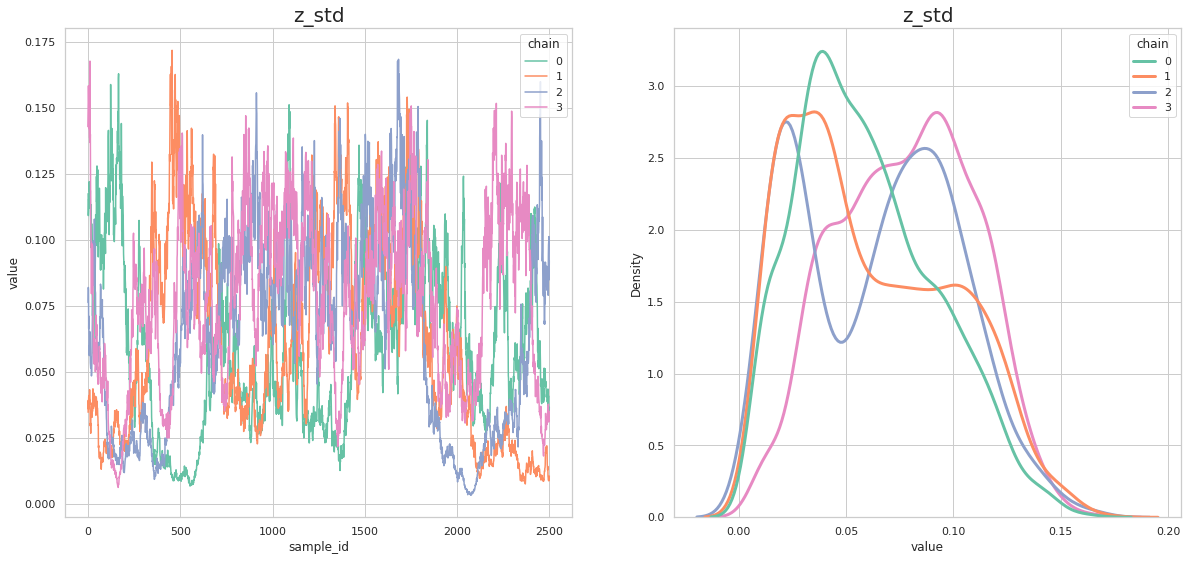

z_trans(high.invalid.inside)


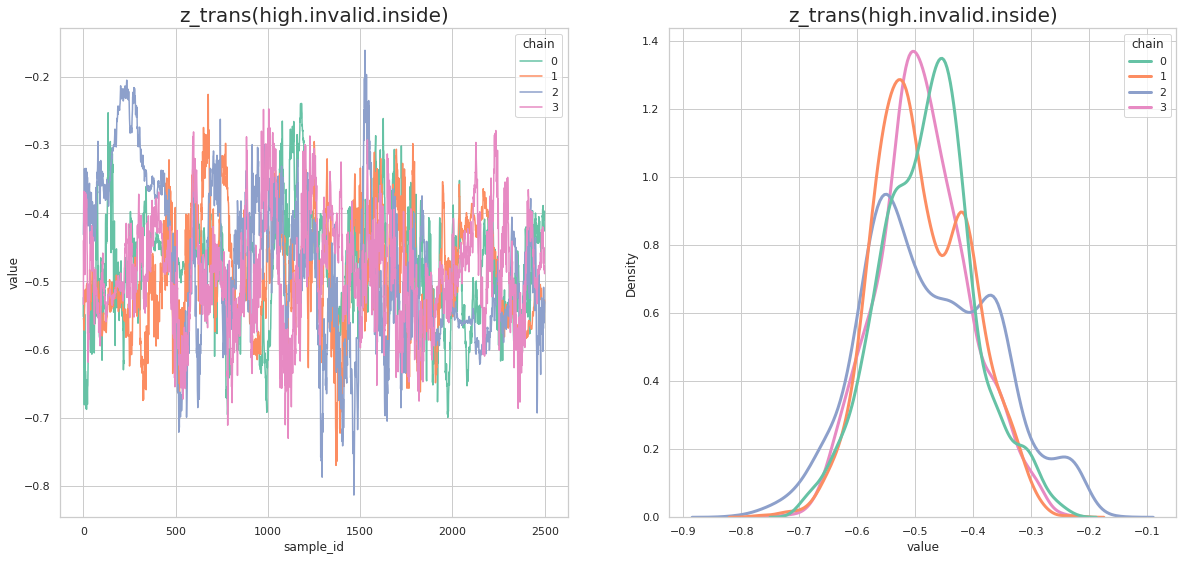

z_trans(high.invalid.outside)


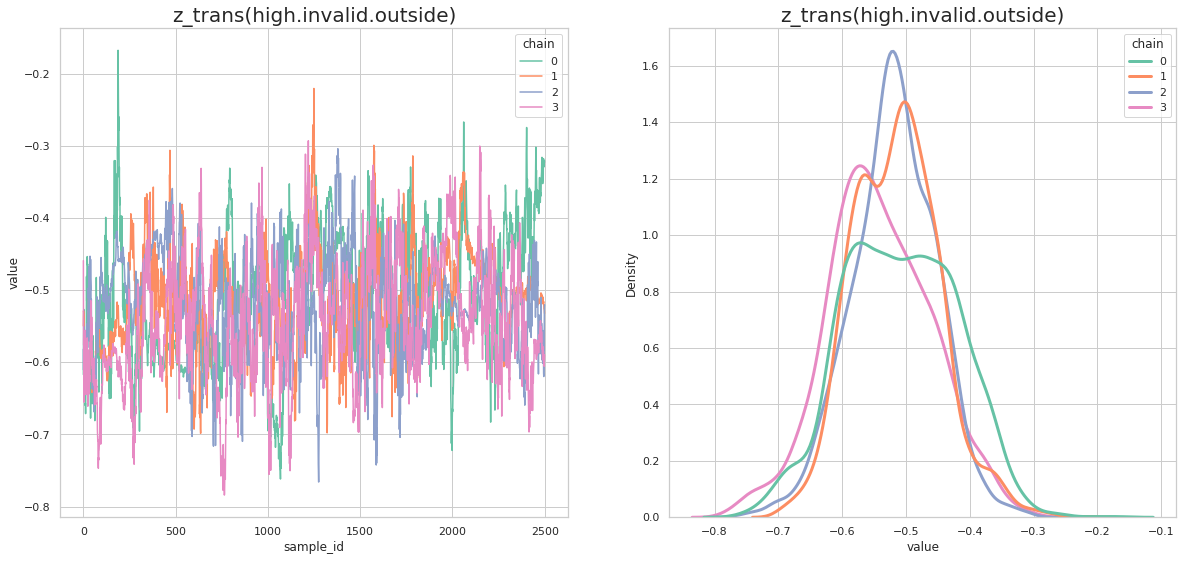

z_trans(high.valid.inside)


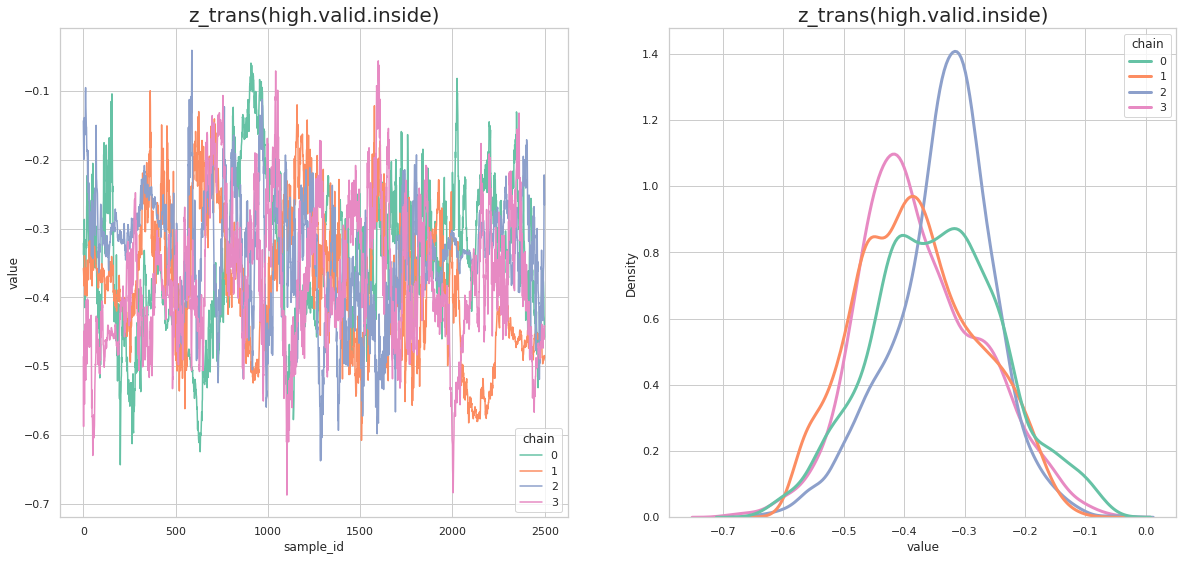

z_trans(high.valid.outside)


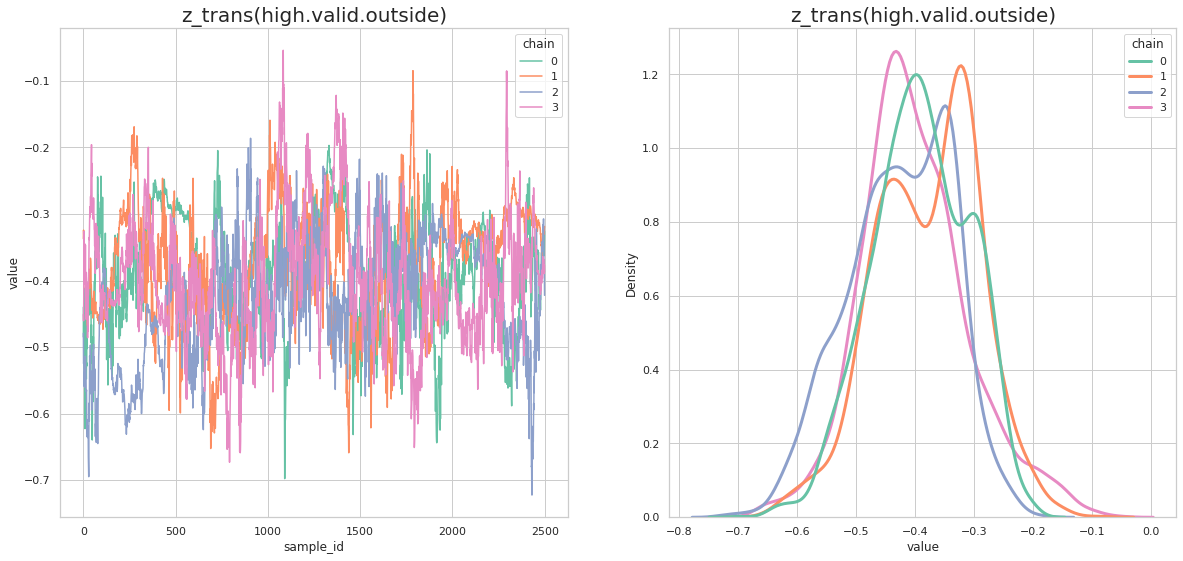

z_trans(low.invalid.inside)


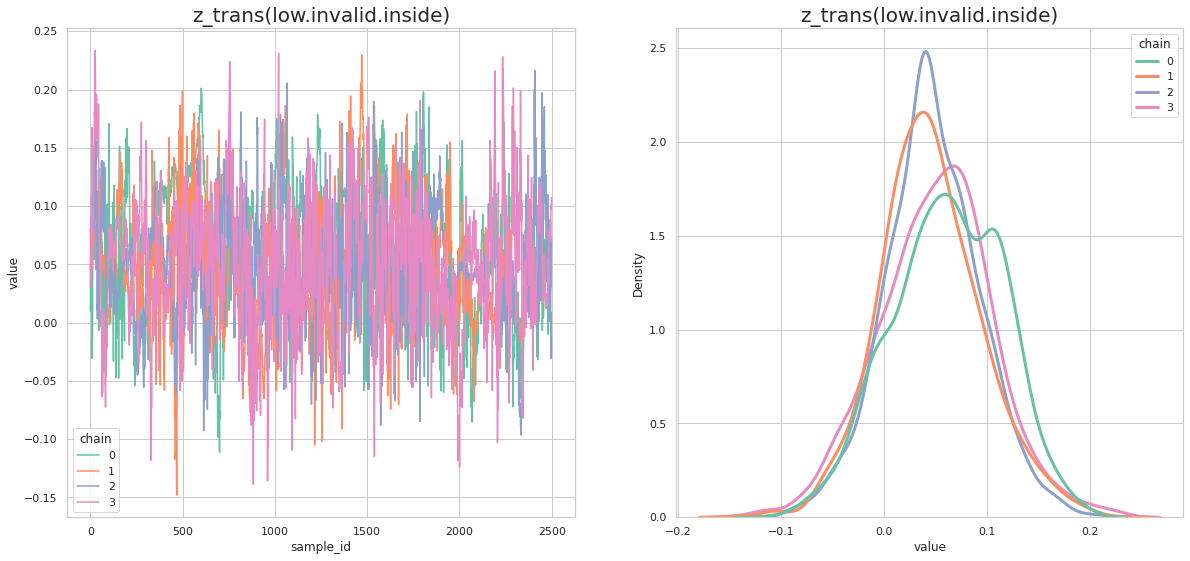

z_trans(low.invalid.outside)


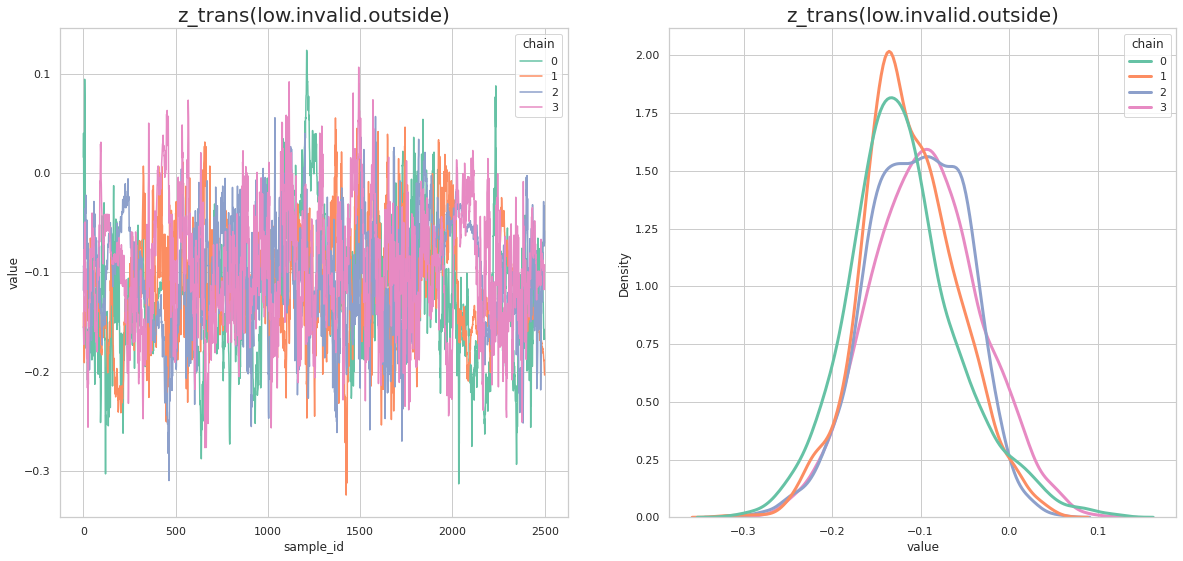

z_trans(low.valid.inside)


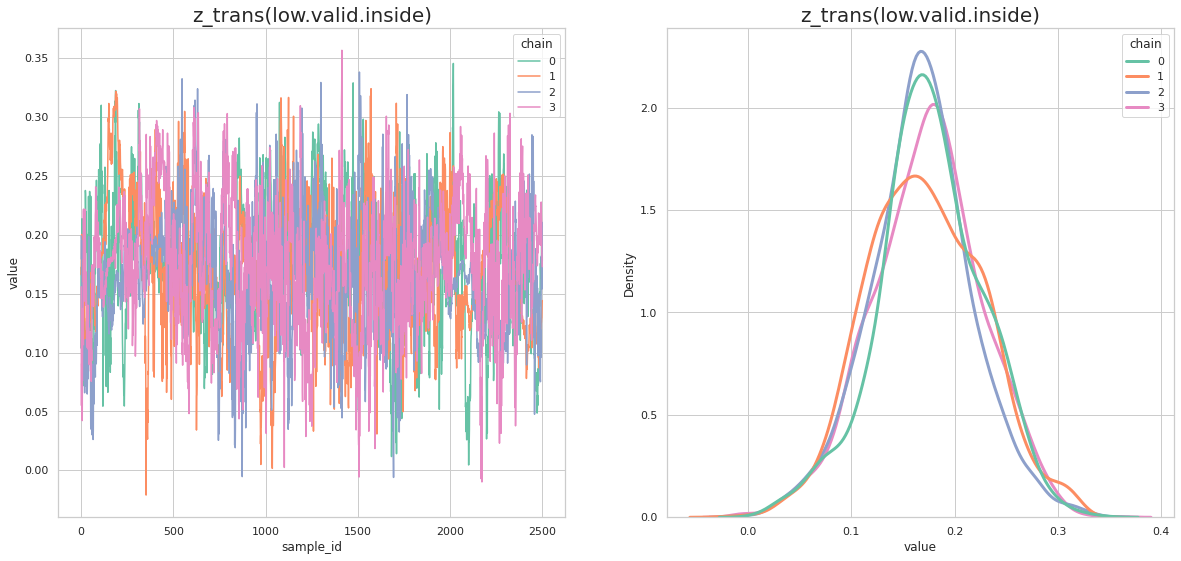

z_trans(low.valid.outside)


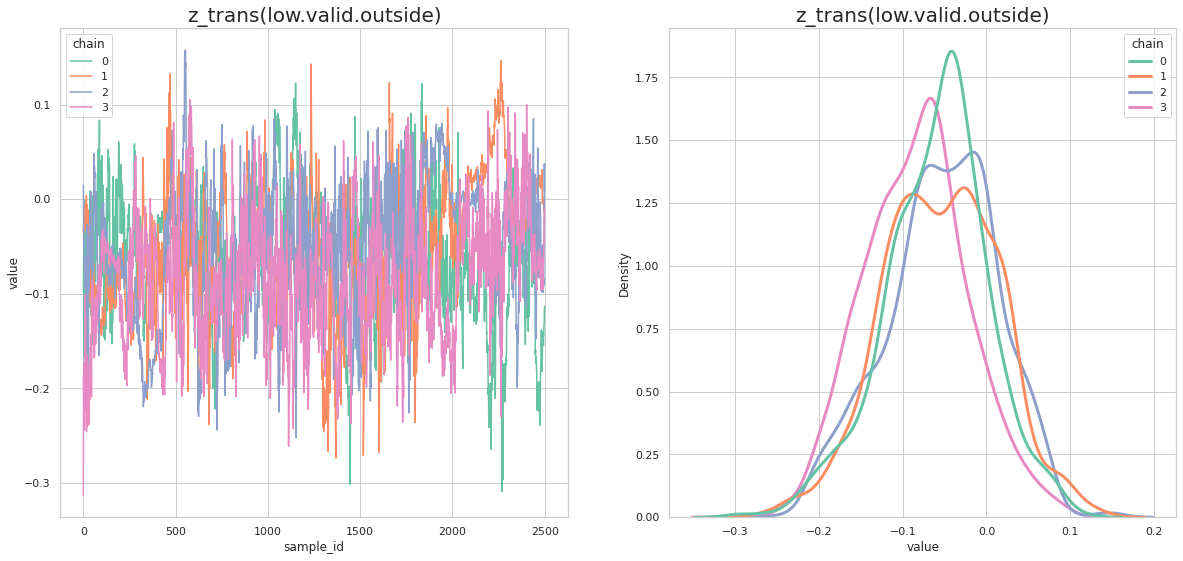

In [19]:
plot_grp_trace(models=M1_models, param='z')

### Model comparision (To-do, after build and estimated multiple models)

Retrieve the posterior traces for plotting and inferences

In [20]:
df_grp_traces_m1 = []
for i in range(4):
    df_m = M1_models[i]
    df_grp_trace = df_m.get_group_traces()
    df_grp_trace['chain'] = i
    print('chain', i, df_grp_trace.shape)
    df_grp_traces_m1.append(df_grp_trace)
    
df_grp_traces_m1 = pd.concat(df_grp_traces_m1)

# select the columns included that parameter

filter_col = [col for col in df_grp_traces_m1 if col.startswith('z')] # filter column names contains v
# filter_col = [col for col in df_grp_traces_m1 if 'std' not in col] # filter column names contains v

filter_col = [col for col in filter_col if 'std' not in col] # filter the std column

filter_col.append('chain') # add the chain column to the data

#df_tmp = df_grp_traces[df_grp_traces.columns.intersection(filter_col)]
df_tmp = df_grp_traces_m1.loc[:, filter_col]
df_tmp["sample_id"] = df_tmp.index

df_melt = pd.melt(df_tmp,
                  id_vars=['sample_id', 'chain'],
                  value_vars=filter_col[:-1],
                  var_name='cond',
                  value_name='value')
df_melt.head()

chain 0 (2500, 37)
chain 1 (2500, 37)
chain 2 (2500, 37)
chain 3 (2500, 37)


,sample_id,chain,cond,value
0,0,0,z_trans(high.invalid.inside),-0.551660
1,1,0,z_trans(high.invalid.inside),-0.523249
2,2,0,z_trans(high.invalid.inside),-0.567854
3,3,0,z_trans(high.invalid.inside),-0.624746
4,4,0,z_trans(high.invalid.inside),-0.627350


In [21]:
df_melt[['params', 'Coherence', 'Cue', 'Status','filler']] = df_melt['cond'].str.split('\(|\.|\)', expand=True)
#df_melt['condition'] = df_melt['condition'].str.rstrip(')')
#df_melt[['Coherence', 'Cue', 'Status']] = df_melt['condition'].str.split(pat='.', expand=True)

df_melt = df_melt[['sample_id', 'chain', 'Status', 'Coherence', 'Cue', 'params', 'value']]

In [22]:
df_melt_p = df_melt
df_melt_p['cond'] = df_melt_p['Cue'] + '_' + df_melt_p['Coherence']
df_melt_p.head()

,sample_id,chain,Status,Coherence,Cue,params,value,cond
0,0,0,inside,high,invalid,z_trans,-0.551660,invalid_high
1,1,0,inside,high,invalid,z_trans,-0.523249,invalid_high
2,2,0,inside,high,invalid,z_trans,-0.567854,invalid_high
3,3,0,inside,high,invalid,z_trans,-0.624746,invalid_high
4,4,0,inside,high,invalid,z_trans,-0.627350,invalid_high


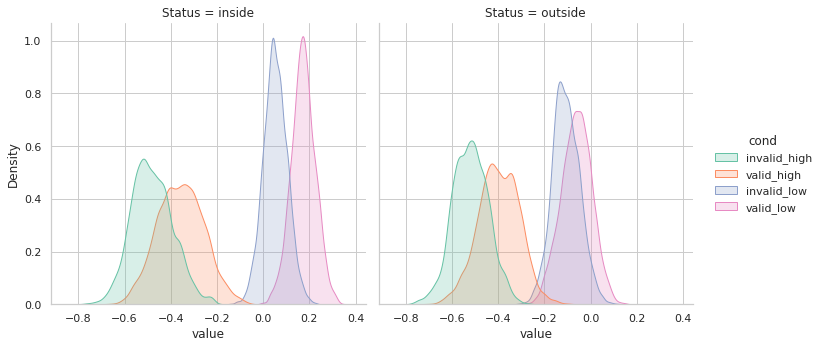

In [23]:
sns.displot(df_melt_p, x="value", col="Status", hue='cond', kind='kde', fill=True)

#### M2: HDDMStimcoding

In this model, we will further assume that different conditions are independent, but we will use stimulus coding instead of accuracy coding.

In [24]:
# define a function to run model in parallel
def run_model_stim(id):
    print('running model%i'%id);
    
    import hddm
    import random
    #import os
    
    #cur_dir = os.getcwd()

    exp_name = 'Ostwald'
    model_tag = 'stim_vat'
    print('running models %i'%id, 'for ', exp_name)
    
    # USE the absolute directory in docker.
    dbname = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id # define the database name, which uses pickle format
    mname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    # define the name for the model
    fname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '.csv'
    df = hddm.load_csv(fname)
    
    m = hddm.HDDMStimCoding(df, 
                        include='z', 
                        stim_col='stim', 
                        depends_on={'v':['status','cue','coherence'], 
                                    'a':['status','cue','coherence'],
                                    't':['status','cue','coherence']},
                        split_param='v', 
                        drift_criterion=False,
                        p_outlier=0.05)
    m.find_starting_values()
    m.sample(5000, burn=2500, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

In [25]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_model_stim, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

models = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
4371.183s elapsed

running model0
running models 0 for  Ostwald
 [-----------------100%-----------------] 5001 of 5000 complete in 4286.2 sec
running model1
running models 1 for  Ostwald
 [-----------------100%-----------------] 5001 of 5000 complete in 4167.9 sec
running model2
running models 2 for  Ostwald
 [-----------------100%-----------------] 5001 of 5000 complete in 4242.5 sec
running model3
running models 3 for  Ostwald
 [-----------------100%-----------------] 5001 of 5000 complete in 4189.1 sec

Running 4 chains used: 4386.220378 seconds.


In [26]:
M2_models = []
for id in range(4):
    mname = 'df_Ostwald_stim_vat_chain_%i'%id   # print('\nProcessing Model ', i)
    m_tmp = hddm.load(mname)
    M2_models.append(m_tmp)

# Create a new model that has all traces concatenated of individual models.
M2_models_comb = kabuki.utils.concat_models(M2_models)

In [27]:
M2_R_hat_vtaz = hddm.analyze.gelman_rubin(M2_models) # get the R hat information
# M1_R_hat_vtz

# save Categ_R_hat_vtz
with open('M2_R_hat_acc_code_vtaz.csv','w') as f:
    w = csv.writer(f)
    w.writerows(M2_R_hat_vtaz.items())

chain 0 (2500, 30)
chain 1 (2500, 30)
chain 2 (2500, 30)
chain 3 (2500, 30)
v(high.invalid.inside)


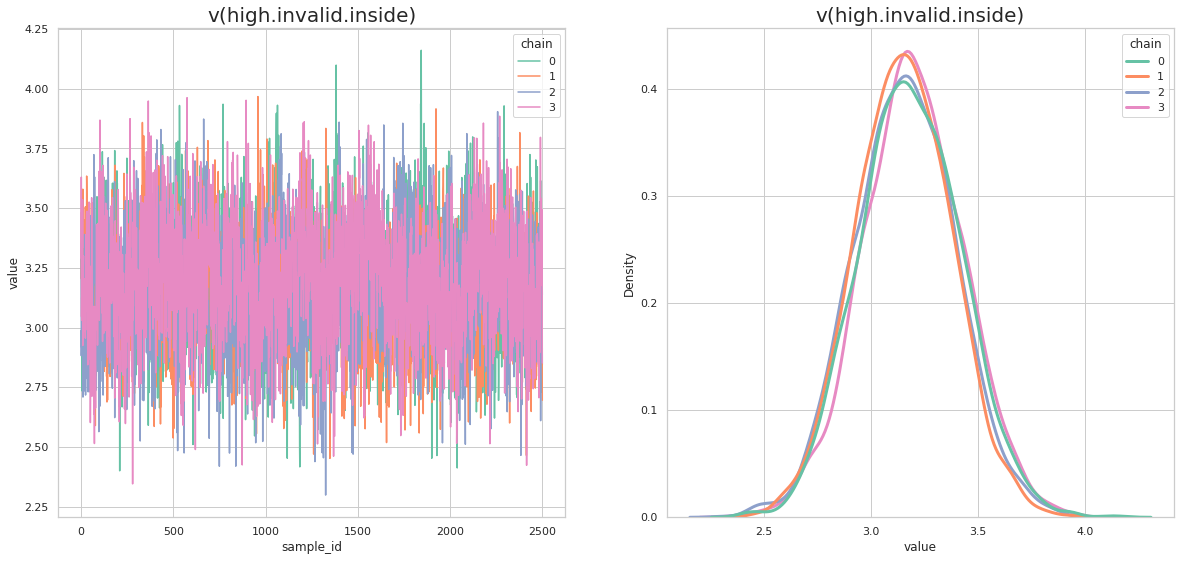

v(high.invalid.outside)


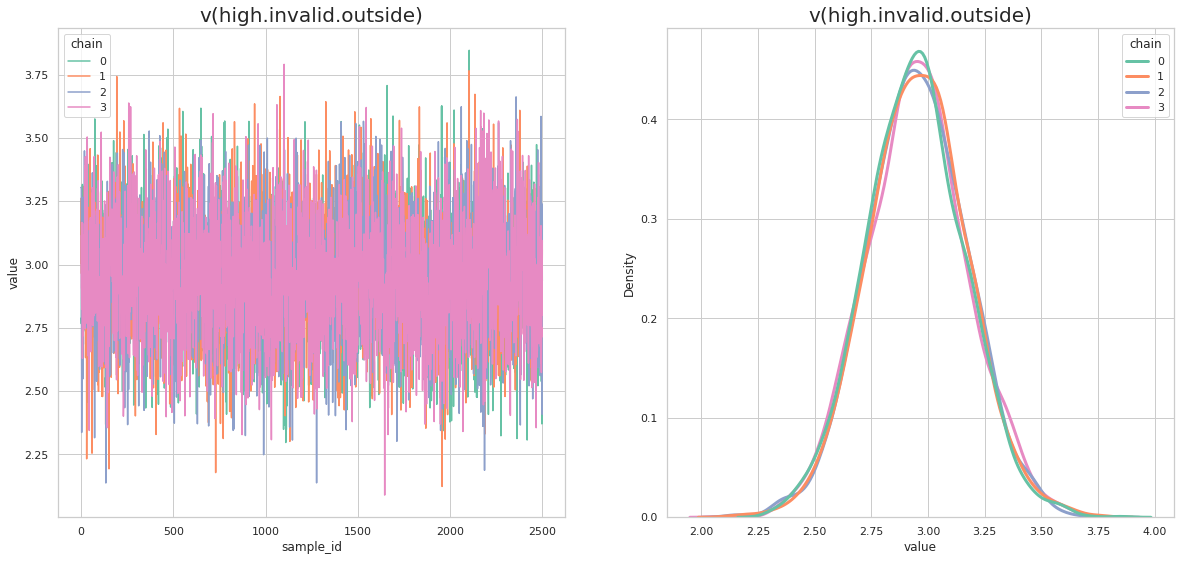

v(high.valid.inside)


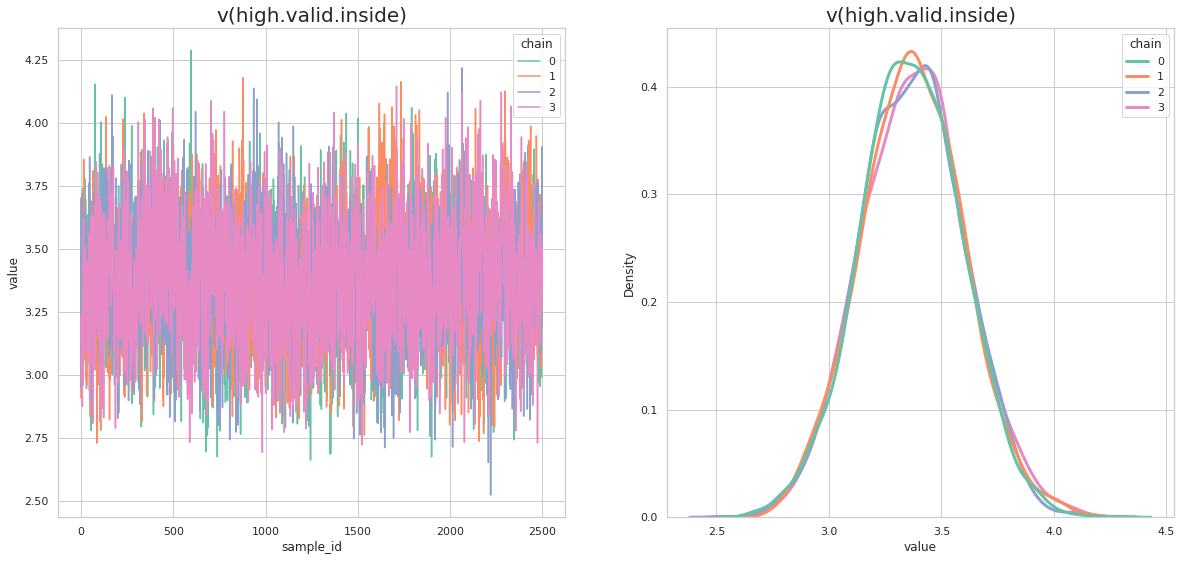

v(high.valid.outside)


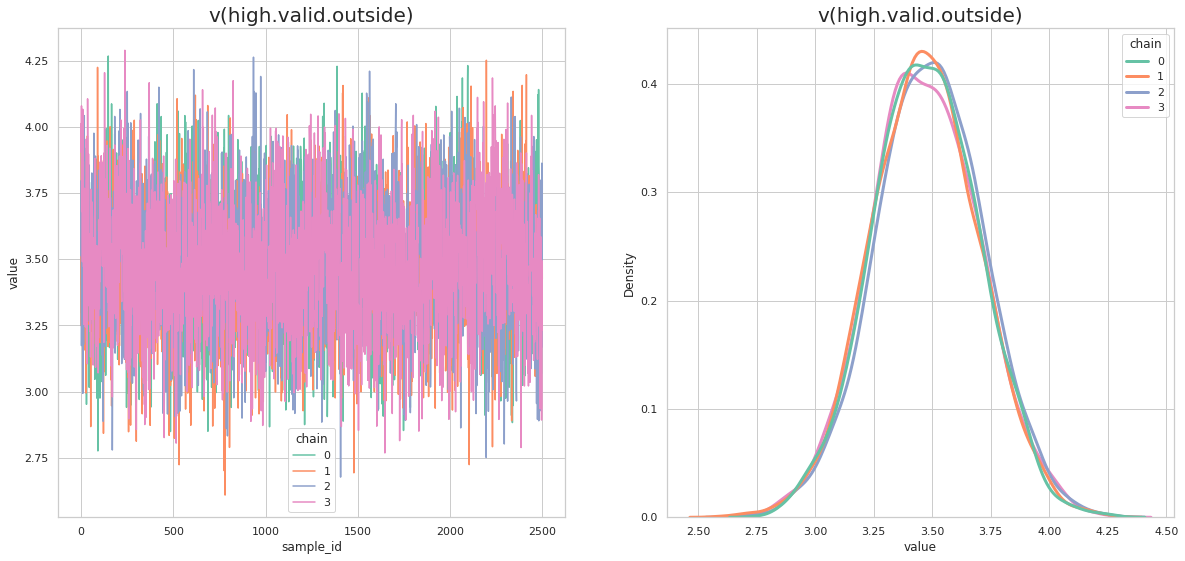

v(low.invalid.inside)


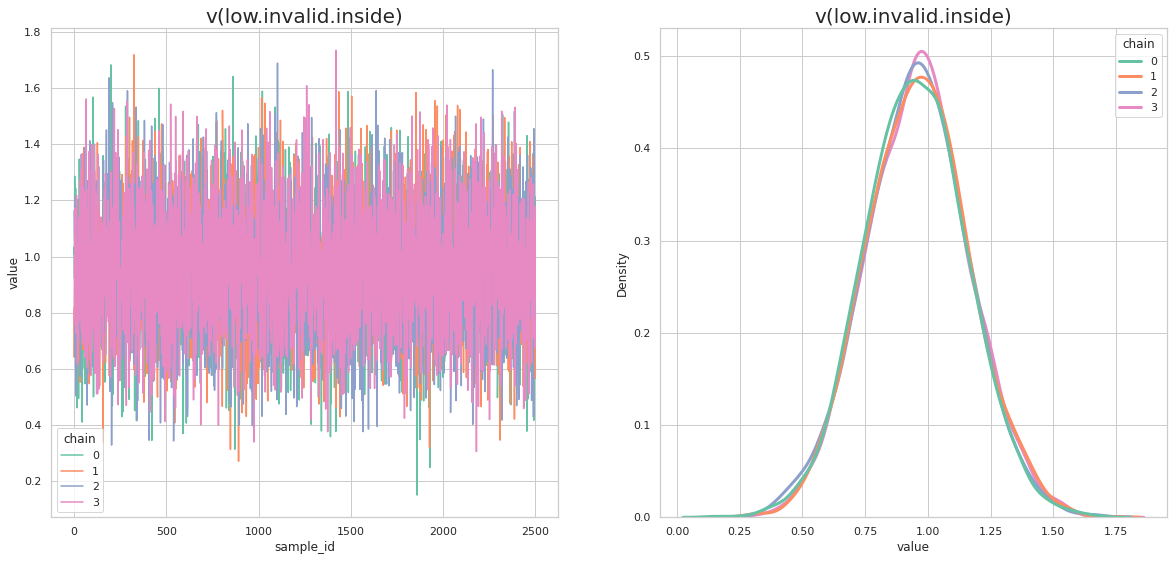

v(low.invalid.outside)


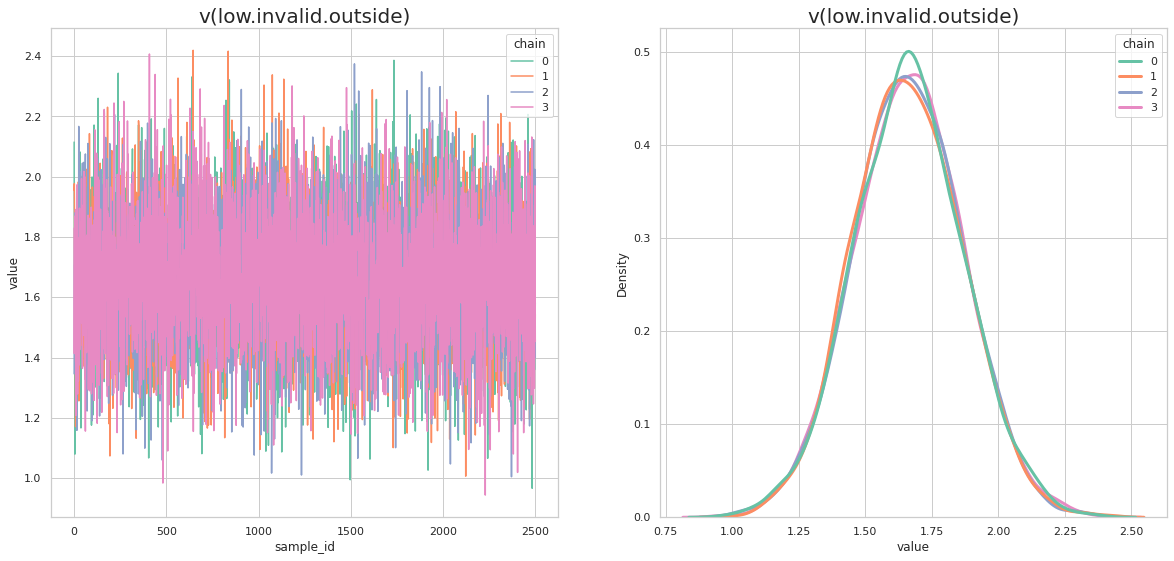

v(low.valid.inside)


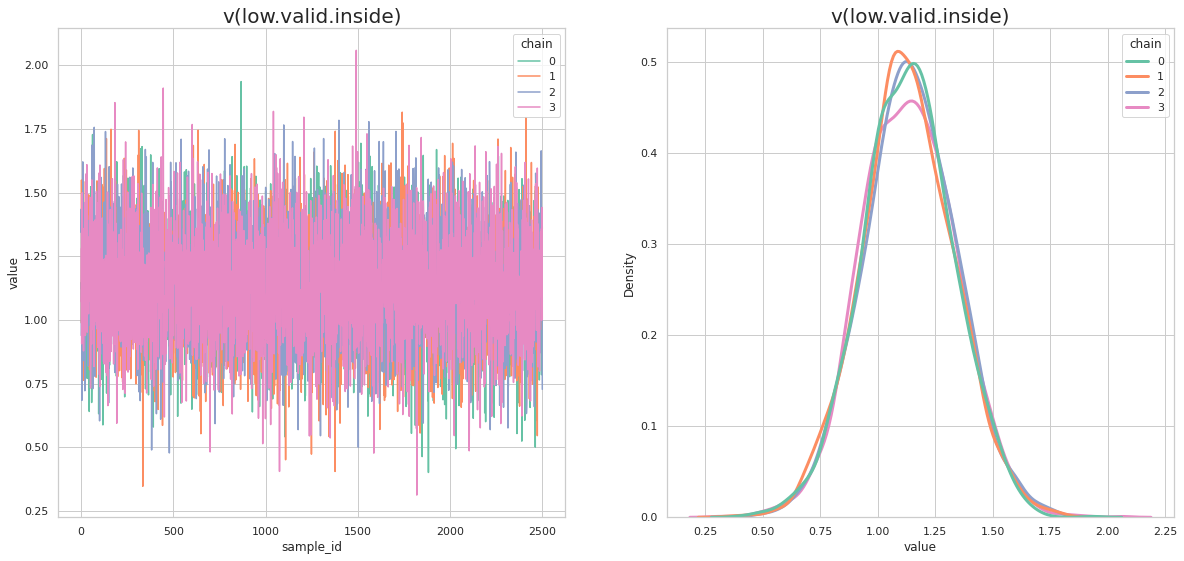

v(low.valid.outside)


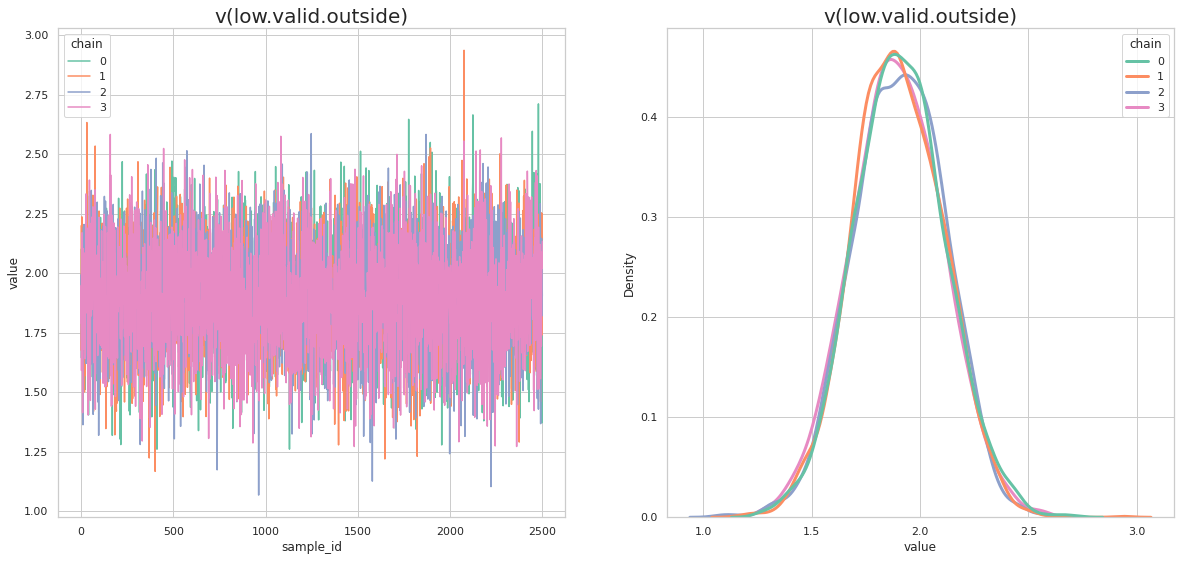

v_std


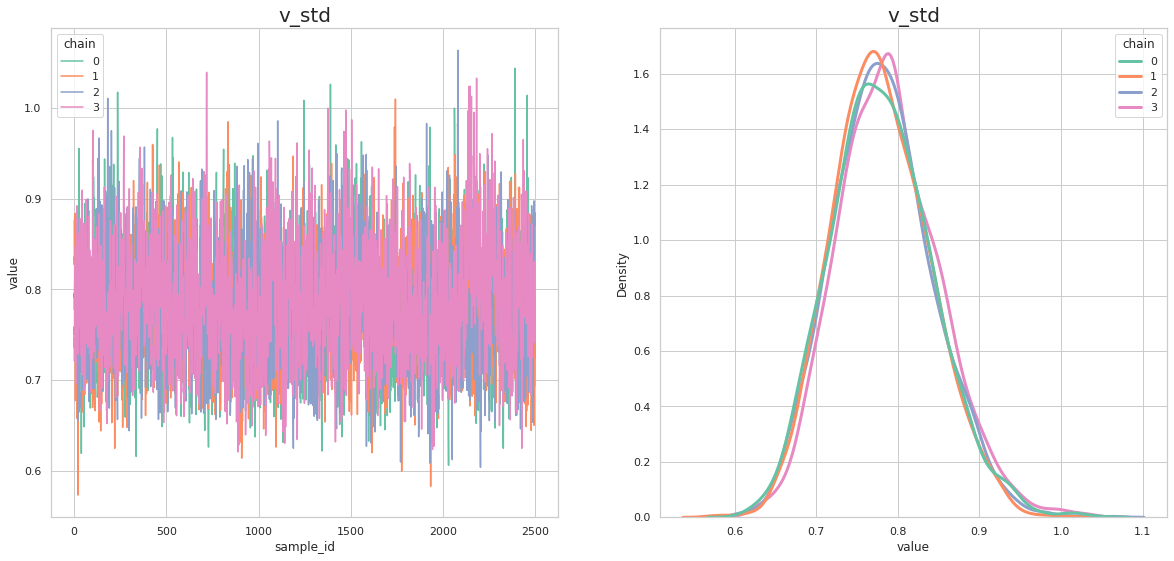

In [30]:
plot_grp_trace(models=M2_models, param='v')

In [35]:
stats = M2_models[0].gen_stats()
stats

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a(high.invalid.inside),1.82149,0.108139,1.63438,1.74579,1.81464,1.88665,2.06386,0.00756014
a(high.invalid.outside),1.4934,0.0744104,1.35165,1.44283,1.49214,1.54122,1.6455,0.00348653
a(high.valid.inside),1.81634,0.0957597,1.63295,1.7519,1.81307,1.87942,2.00523,0.00613299
a(high.valid.outside),1.58241,0.0866958,1.42388,1.5224,1.57654,1.63911,1.75734,0.00505299
a(low.invalid.inside),1.29089,0.0608608,1.17447,1.25068,1.29024,1.33025,1.41361,0.00153301
...,...,...,...,...,...,...,...,...
z_subj.13,0.524785,0.0106656,0.503877,0.51751,0.524962,0.531775,0.546182,0.000273208
z_subj.14,0.586737,0.0109864,0.56592,0.579262,0.586394,0.59426,0.608848,0.000252353
z_subj.15,0.481245,0.00971185,0.462043,0.474995,0.481046,0.48752,0.500933,0.000230697
z_subj.16,0.560117,0.00996145,0.540566,0.553492,0.560223,0.566651,0.579224,0.000283842


In [10]:
m_stats = M1.gen_stats()
m_stats['params'] = m_stats.index
m_stats.head()


,mean,std,2.5q,25q,50q,75q,97.5q,mc err,params
a(high.invalid.inside),4.87085,0.318156,4.24451,4.66166,4.87598,5.08739,5.50138,0.00796208,a(high.invalid.inside)
a(high.invalid.outside),1.84546,0.207797,1.43966,1.70466,1.8459,1.98044,2.26195,0.00428506,a(high.invalid.outside)
a(high.valid.inside),5.07782,0.309129,4.44391,4.87304,5.08508,5.28402,5.66106,0.00580671,a(high.valid.inside)
a(high.valid.outside),1.78556,0.199244,1.40188,1.65001,1.78074,1.91759,2.1879,0.00460847,a(high.valid.outside)
a(low.invalid.inside),2.44463,0.250966,1.94602,2.27828,2.44432,2.60926,2.94204,0.00457773,a(low.invalid.inside)


In [11]:
m_stats_subj = m_stats[m_stats['params'].str.contains("v_subj")]
m_stats_subj[['param','subj']] = m_stats_subj['params'].str.split("_",expand=True) 
m_stats_subj[['subj','conds','subj_idx']] = m_stats_subj['subj'].str.split("\(|\)",expand=True) 
m_stats_subj[['subj_idx']] = m_stats_subj['subj_idx'].str.split(".",expand=True)[1][:,np.newaxis]
#m_stats_subj[['coherence', 'cue', 'status']] = m_stats_subj['conds'].str.split(".",expand=True).loc[:,0:2]
m_stats_subj = m_stats_subj[['subj_idx', 'conds', 'param', 'mean']].copy()

m_stats_subj.head()



,subj_idx,conds,param,mean
v_subj(high.invalid.inside).2,2,high.invalid.inside,v,3.53341
v_subj(high.invalid.inside).3,3,high.invalid.inside,v,4.98348
v_subj(high.invalid.inside).4,4,high.invalid.inside,v,5.98156
v_subj(high.invalid.inside).5,5,high.invalid.inside,v,7.43326
v_subj(high.invalid.inside).6,6,high.invalid.inside,v,4.60577


In [12]:

m_stats_subj_wide = m_stats_subj.pivot_table(index=['subj_idx'], 
                                 columns=['param', 'conds'],
                                 aggfunc='first', 
                                 values = 'mean',     
                                 fill_value=0) 
#m1_stats_subj_wide.columns = m1_stats_subj_wide.columns.map('_'.join)
m_stats_subj_wide.reset_index(inplace=True)  

# reset the index
#m_stats_subj_wide.index = df_params.index

# change the data type of 'subj_idx'
m_stats_subj_wide['subj_idx'] = m_stats_subj_wide['subj_idx'].astype(int)
m_stats_subj_wide.columns = ['_'.join(col).strip() for col in m_stats_subj_wide.columns.values]

m_stats_subj_wide.head()

,subj_idx_,v_high.invalid.inside,v_high.invalid.outside,v_high.valid.inside,v_high.valid.outside,v_low.invalid.inside,v_low.invalid.outside,v_low.valid.inside,v_low.valid.outside
0,1,0.000000,4.366877,0.000000,3.237330,0.000000,4.375789,0.000000,3.788913
1,10,8.242080,2.585527,7.271292,4.536803,3.838258,1.927173,3.560574,2.641821
2,11,3.696755,1.168598,4.274861,2.175353,0.380342,0.401856,0.096920,0.737850
3,12,6.459364,4.135310,7.332550,4.215599,0.796895,1.995280,1.259812,2.975133
4,13,5.626471,2.832245,5.899269,3.113820,0.646277,1.593034,0.705816,1.386766


In [13]:
m_stats_subj_wide = m_stats_subj_wide.replace(0, np.nan)
m_stats_subj_wide.head()

,subj_idx_,v_high.invalid.inside,v_high.invalid.outside,v_high.valid.inside,v_high.valid.outside,v_low.invalid.inside,v_low.invalid.outside,v_low.valid.inside,v_low.valid.outside
0,1,NaN,4.366877,NaN,3.237330,NaN,4.375789,NaN,3.788913
1,10,8.242080,2.585527,7.271292,4.536803,3.838258,1.927173,3.560574,2.641821
2,11,3.696755,1.168598,4.274861,2.175353,0.380342,0.401856,0.096920,0.737850
3,12,6.459364,4.135310,7.332550,4.215599,0.796895,1.995280,1.259812,2.975133
4,13,5.626471,2.832245,5.899269,3.113820,0.646277,1.593034,0.705816,1.386766


In [14]:
p_m_stats_subj_wide = m_stats_subj_wide.drop(['subj_idx_'], axis = 1)
p_m_stats_subj_wide.head()

,v_high.invalid.inside,v_high.invalid.outside,v_high.valid.inside,v_high.valid.outside,v_low.invalid.inside,v_low.invalid.outside,v_low.valid.inside,v_low.valid.outside
0,NaN,4.366877,NaN,3.237330,NaN,4.375789,NaN,3.788913
1,8.242080,2.585527,7.271292,4.536803,3.838258,1.927173,3.560574,2.641821
2,3.696755,1.168598,4.274861,2.175353,0.380342,0.401856,0.096920,0.737850
3,6.459364,4.135310,7.332550,4.215599,0.796895,1.995280,1.259812,2.975133
4,5.626471,2.832245,5.899269,3.113820,0.646277,1.593034,0.705816,1.386766


In [15]:
# plt.matshow(.corr())
# plt.show()

corr = p_m_stats_subj_wide.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,v_high.invalid.inside,v_high.invalid.outside,v_high.valid.inside,v_high.valid.outside,v_low.invalid.inside,v_low.invalid.outside,v_low.valid.inside,v_low.valid.outside
v_high.invalid.inside,1.00,0.58,0.77,0.80,0.31,0.65,0.22,0.54
v_high.invalid.outside,0.58,1.00,0.54,0.58,0.23,0.81,0.21,0.81
v_high.valid.inside,0.77,0.54,1.00,0.58,0.12,0.50,0.20,0.42
v_high.valid.outside,0.80,0.58,0.58,1.00,0.09,0.39,0.17,0.49
v_low.invalid.inside,0.31,0.23,0.12,0.09,1.00,0.43,0.53,0.49
v_low.invalid.outside,0.65,0.81,0.50,0.39,0.43,1.00,0.17,0.89
v_low.valid.inside,0.22,0.21,0.20,0.17,0.53,0.17,1.00,0.28
v_low.valid.outside,0.54,0.81,0.42,0.49,0.49,0.89,0.28,1.00


In [30]:
m_stats_subj_wide.groupby(['coherence', 'cue', 'status'])[['v']].corr()

param                              v
coherence cue     status  param     
high      invalid inside  v      1.0
                  outside v      1.0
          valid   inside  v      1.0
                  outside v      1.0
low       invalid inside  v      1.0
                  outside v      1.0
          valid   inside  v      1.0
                  outside v      1.0

In [7]:
df_grp_trace.head()

,a,a_std,v(high.invalid.inside),v(high.invalid.outside),v(high.valid.inside),v(high.valid.outside),v(low.invalid.inside),v(low.invalid.outside),v(low.valid.inside),v(low.valid.outside),...,t(high.valid.inside),t(high.valid.outside),t(low.invalid.inside),t(low.invalid.outside),t(low.valid.inside),t(low.valid.outside),t_std,z_trans,z_std,chain
0,1.360751,0.082762,2.448680,2.806875,2.806716,2.894220,1.091365,1.653491,1.377813,1.924445,...,0.469935,0.169559,0.524590,0.189442,0.506718,0.220311,0.071078,0.132027,0.155514,0
1,1.347762,0.108492,2.336532,2.730557,2.888763,2.891293,1.078666,1.590468,1.509509,2.260636,...,0.440999,0.179517,0.484637,0.173055,0.495251,0.200118,0.070719,0.120817,0.159678,0
2,1.389272,0.141898,2.279391,2.968125,2.437985,2.862628,0.615956,1.684060,1.236967,2.089604,...,0.466403,0.196443,0.532632,0.232407,0.509338,0.193033,0.066998,0.112068,0.123168,0
3,1.364854,0.104165,2.664177,2.617920,2.982518,2.541084,0.782666,1.694769,1.065067,2.207131,...,0.484439,0.182947,0.521685,0.198546,0.486822,0.224819,0.067897,0.192509,0.137635,0
4,1.336141,0.158270,2.663445,2.921772,2.901848,2.923423,0.694825,1.482003,1.275899,1.827823,...,0.441110,0.166094,0.530369,0.211849,0.473051,0.222356,0.066805,0.211883,0.112792,0


Check the model fitting using PPC and DIC: